In [1]:
# 데이터 구성 : Series, DataFrame
import pandas as pd

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# export_graphviz : 나무 구조 생성 및 저장
# from sklearn.tree import export_graphviz
# graphviz : 나무 구조 시각화 (.확장자 파일 불러오기 등)
# import graphviz

# 데이터 분할 : train, test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# 예측/회귀 Decision Tree
from sklearn.tree import DecisionTreeRegressor

# 나무 구조 시각화  
from sklearn.tree import plot_tree

In [2]:
matplotlib.rc("font", family = "Malgun Gothic")

### 데이터 구성하기

In [3]:
df_raw = pd.read_csv("C:/Users/Myung-jin/21aibigdata/bigdata/Concrete.CSV")
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["strength"]
df_raw_x = df_raw.drop("strength", axis=1, inplace = False)

데이터 분할 (train, test 데이터를 6:4 비율로 분할)

In [5]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y,
                                                               test_size = 0.4, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (618, 8)
train data Y size : (618,)
test data X size : (412, 8)
test data Y size : (412,)


> train 데이터는 618개, test 데이터는 412개이다.

### 모델 생성
#### 기본 옵션으로 모델 생성

In [6]:
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set : {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on training set : 0.996
Score on test set : 0.790


> training set과 test set에 대해 결정계수를 구해보았더니 둘 다 결정계수가 높게 나왔다.   
  모델 설명력이 train 99.6%, test 79%로 모델은 train 데이터에 과적합한 것을 알 수 있다.   
  그래서 의사결정나무를 생성하며 모델 parameter 조정을 통해 train 데이터 설명력을 낮추고  
  test 데이터에 대한 설명력을 조금 더 높일 수 있도록 조정해보고자 한다.

In [7]:
tree_uncustomized

DecisionTreeRegressor(random_state=1234)

#### 모델 Parameter 조정
##### - min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [8]:
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf = [n_leaf * 1 for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

In [9]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.996,0.790
1,2,0.978,0.783
2,3,0.959,0.786
3,4,0.943,0.796
4,5,0.934,0.811
5,6,0.920,0.810
6,7,0.909,0.799
7,8,0.900,0.792
8,9,0.877,0.817
9,10,0.868,0.816


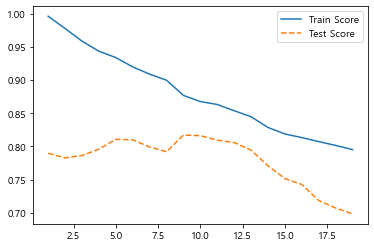

In [10]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label= "Test Score")
plt.legend()

> leaf node 최소 자료 수가 증가할수록 모델의 설명력은 감소한다. 그래서 train, test 데이터의 성능 변화를 고려하여  
  잎사귀 노드의 최소 자료 수를 5와 9 두 개를 선정하여 모델의 성능을 비교해보고자 한다.

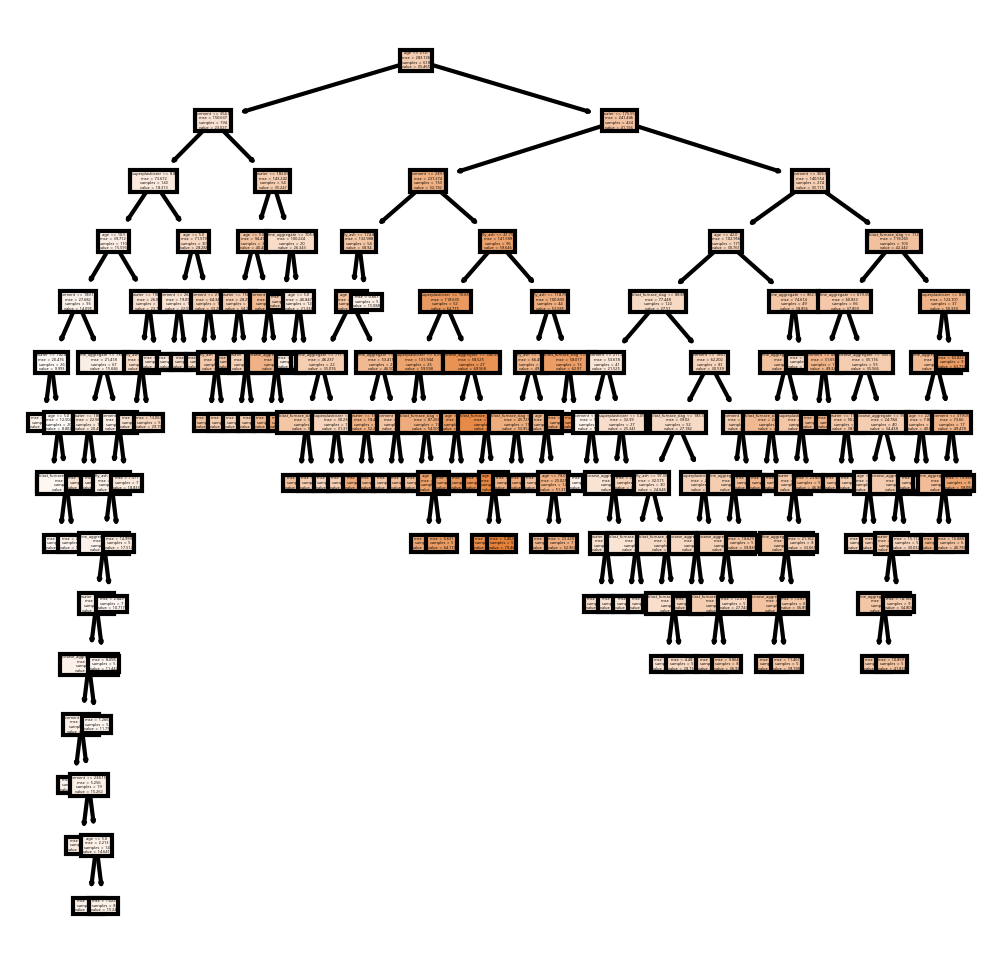

In [11]:
# 변수명 저장
v_feature_name = df_train_x.columns
# 노드의 최소 자료 수 = 5 모델
tree_graph = DecisionTreeRegressor(random_state=1234,  min_samples_leaf=5 )
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

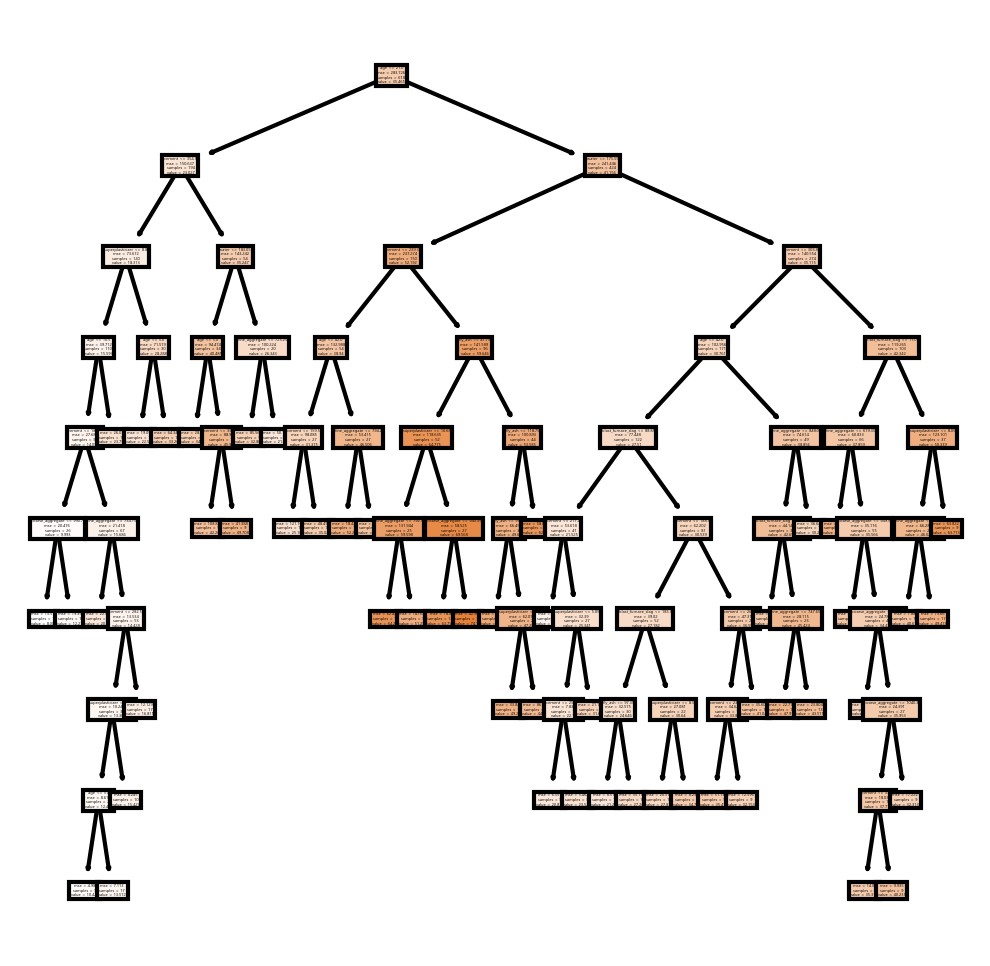

In [12]:
# 노드의 최소 자료 수 = 9 모델
tree_graph = DecisionTreeRegressor(random_state=1234,  min_samples_leaf=9 )
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);


> 잎사귀 노드 최소 자료수를 5로 선택하면 train score는 9를 선택하는 것에 비해 훨씬 높아지나,  
  모델을 보았을 때 최소 자료수가 9일 때 좀 더 균형적으로 분리 되어 있음을 육안으로 확인할 수 있다.  
> **하지만 둘 다 객관적으로 균형적으로 분리되어 있다고 보긴 힘들다. 즉 데이터가 한쪽으로 치우친 데이터일 것이라고 예측할 수 있다.**

##### - min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [13]:
train_score = []; test_score = []
para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=9,
                                min_samples_split = v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.877,0.817
1,6,0.877,0.817
2,8,0.877,0.817
3,10,0.877,0.817
4,12,0.877,0.817
5,14,0.877,0.817
6,16,0.877,0.817
7,18,0.877,0.817
8,20,0.874,0.817
9,22,0.870,0.809


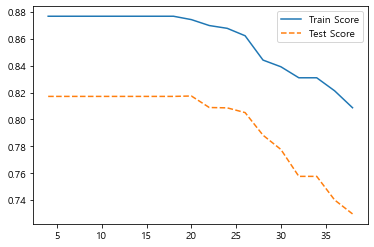

In [14]:
plt.plot(para_split, train_score, linestyle = "-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label= "Test Score")
plt.legend()

> 분리 노드의 최소 자료 수가 증가하면 모델의 설명력은 감소한다. train과 test 데이터의 성능 변화를 고려하여 18과 20을 선택한다.   
  test score는 20 후로 계속하여 급격하게 떨어지기 때문이다. 두 파라미터에 대한 모델 성능을 비교해보자. 

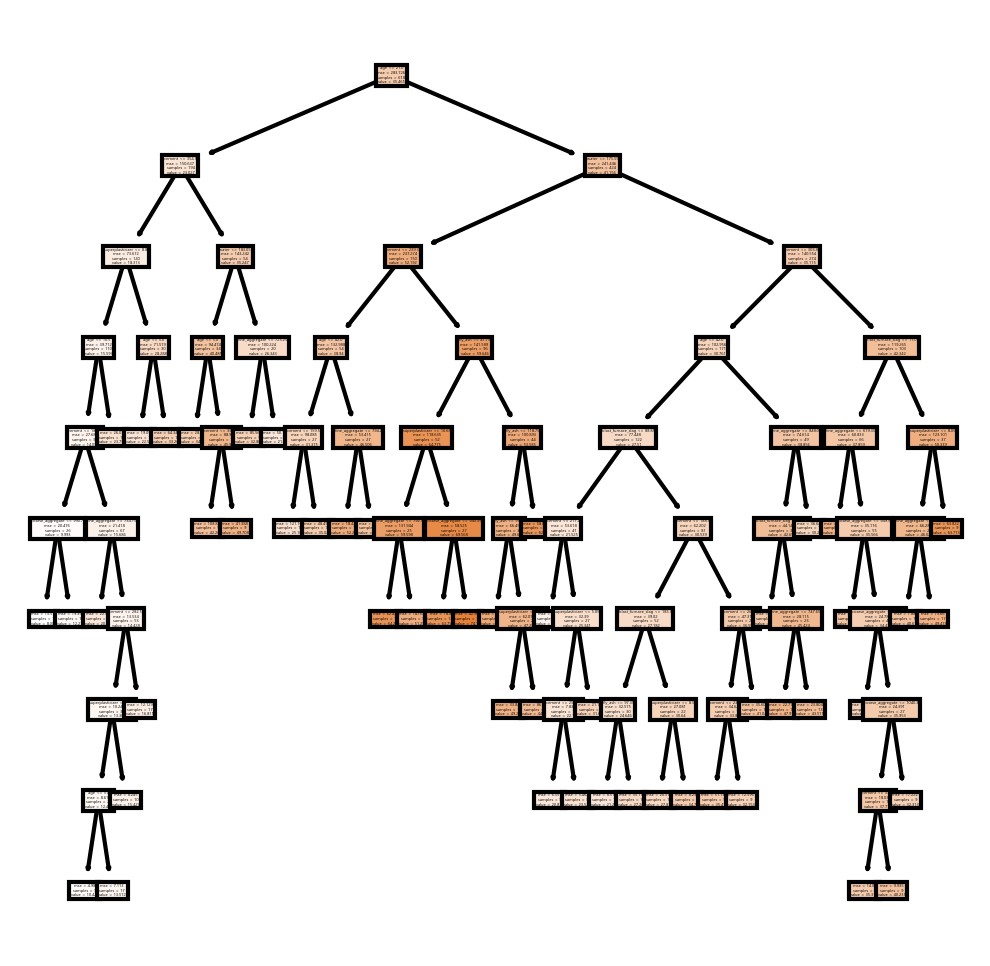

In [15]:
# 분리 노드의 최소 자료 수= 18 모델
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=9, min_samples_split= 18 )
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);


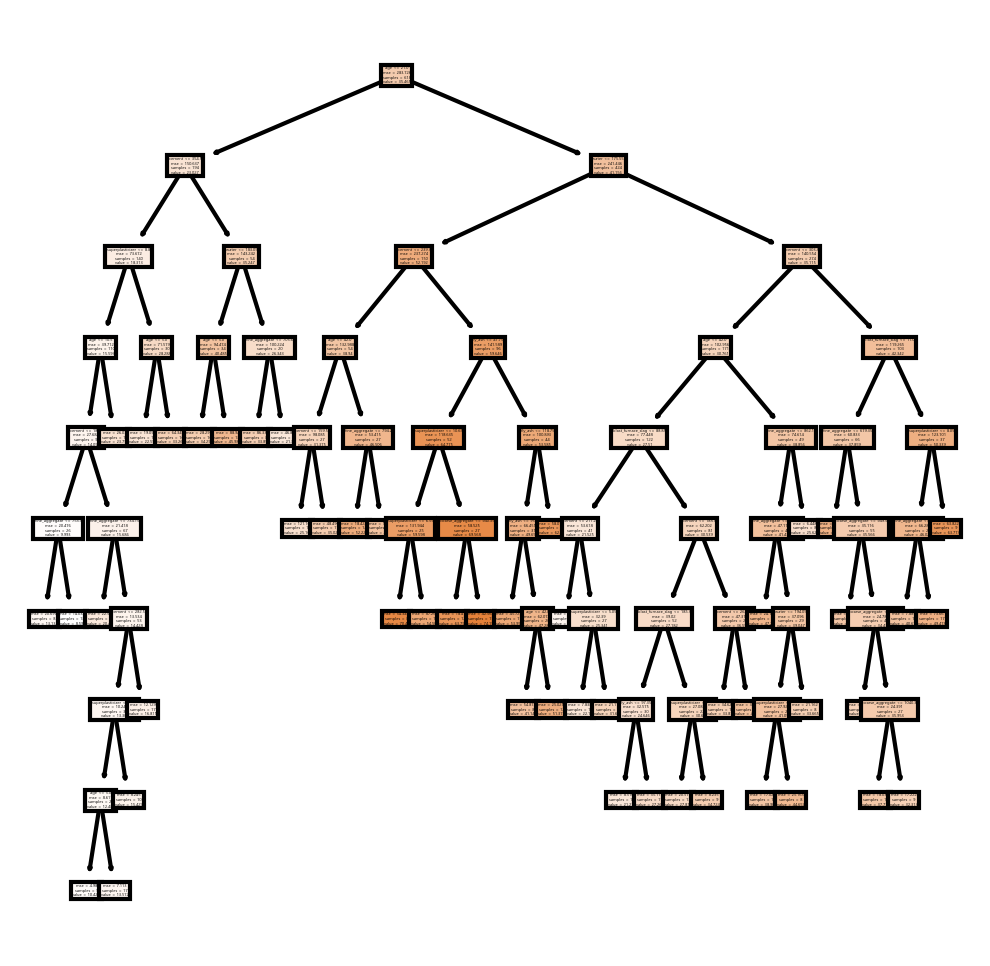

In [16]:
# 분리 노드의 최소 자료 수= 20 모델
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=8, min_samples_split=20 )
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);


> 육안으로 두 모델은 크게 다르지 않기 때문에, 최소 자료수를 증가시키면 과적합이 방지되는 원리에 따라   
  분리 노드의 최소 자료 수를 20으로 선정했다.

##### - max_depth : 최대 깊이 변경에 따른 모델 성능

In [17]:
train_score = []; test_score = []
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=9,
                                min_samples_split =20, max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score


In [18]:
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.877,0.817
1,6,0.877,0.817
2,8,0.877,0.817
3,10,0.877,0.817
4,12,0.877,0.817
5,14,0.877,0.817
6,16,0.877,0.817
7,18,0.877,0.817
8,20,0.874,0.817
9,22,0.870,0.809


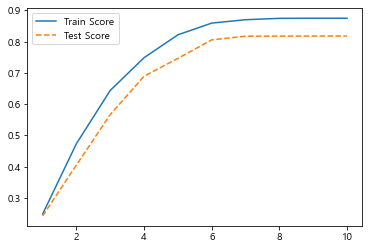

In [19]:
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.legend()

> 최대 깊이 증가에 따라 모델의 설명력은 좋아지는데, train/test 성능 변화를 고려하여 4와 6을 선택한다.
  이제 모델을 구현하여 비교해보자.

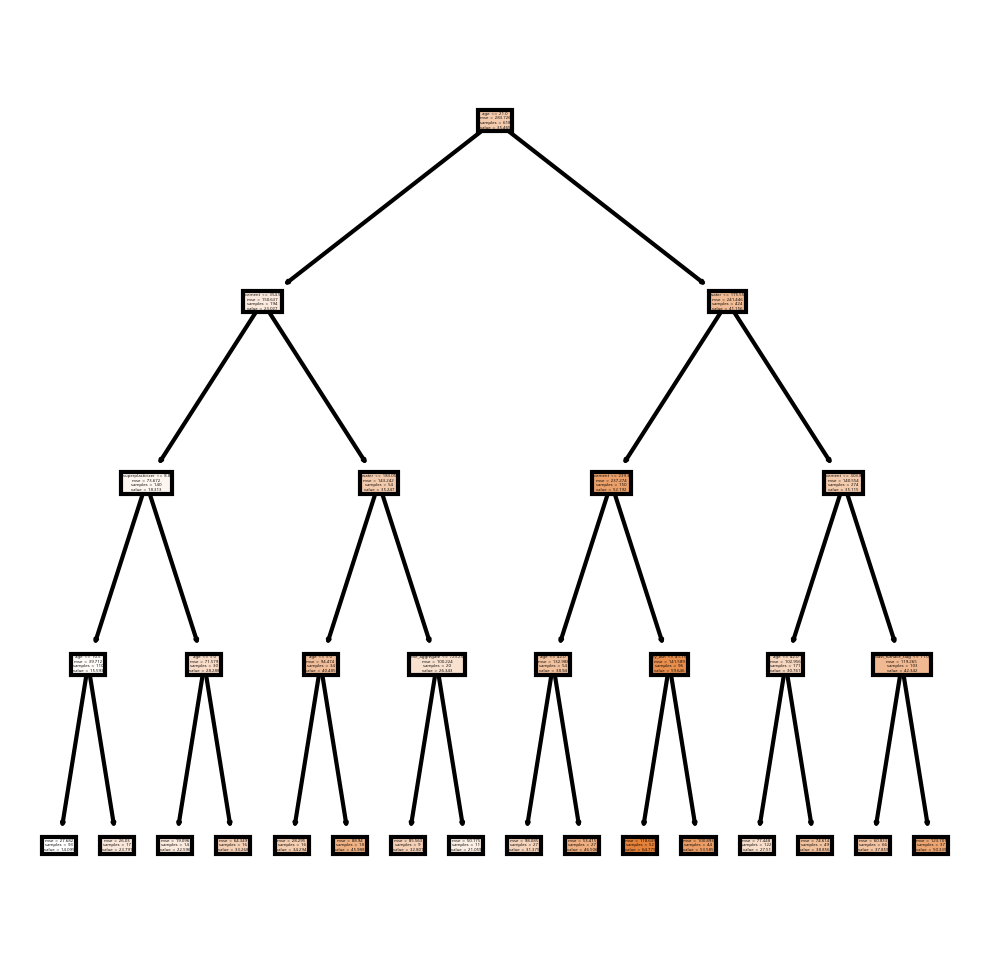

In [20]:
# 최대 깊이 = 4
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=9, min_samples_split=20,
                                  max_depth=4)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);


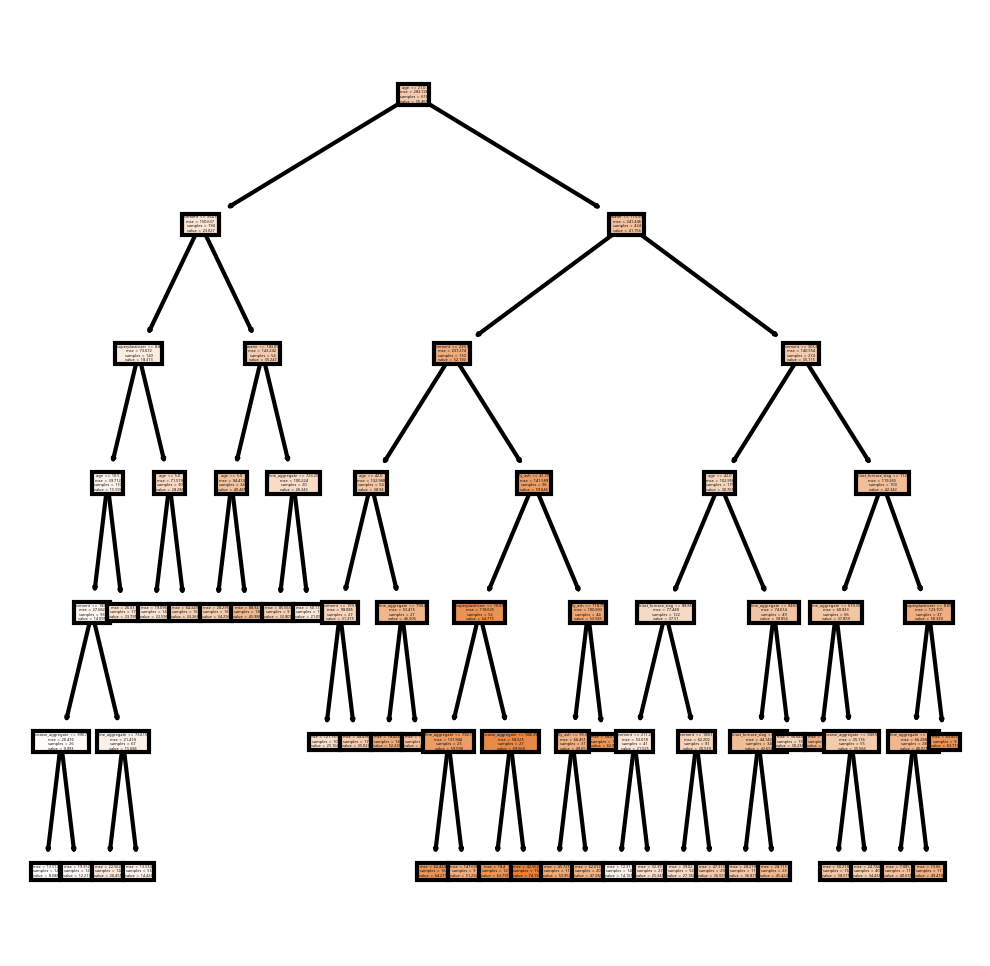

In [21]:
# 최대 깊이 6
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=9, min_samples_split=20,
                                  max_depth=6)
tree_graph.fit(df_train_x, df_train_y)
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);


> 깊이 4는 leaf 노드도 각각 부모노드에 2개로 분리가 되어있고, 데이터양이 많기 때문에 과소적합하지 않나 판단이 든다.   
  그래서 데이터를 좀 더 많이 설명할 수 있는 깊이 6을 선정했다.

### 최종 모델 선정

In [22]:
tree_final = DecisionTreeRegressor(min_samples_leaf=9, min_samples_split=20,
                                  max_depth=6, random_state = 1234)
tree_final.fit(df_train_x, df_train_y)
print("Score on training set : {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set : {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on training set : 0.859
Score on test set : 0.805


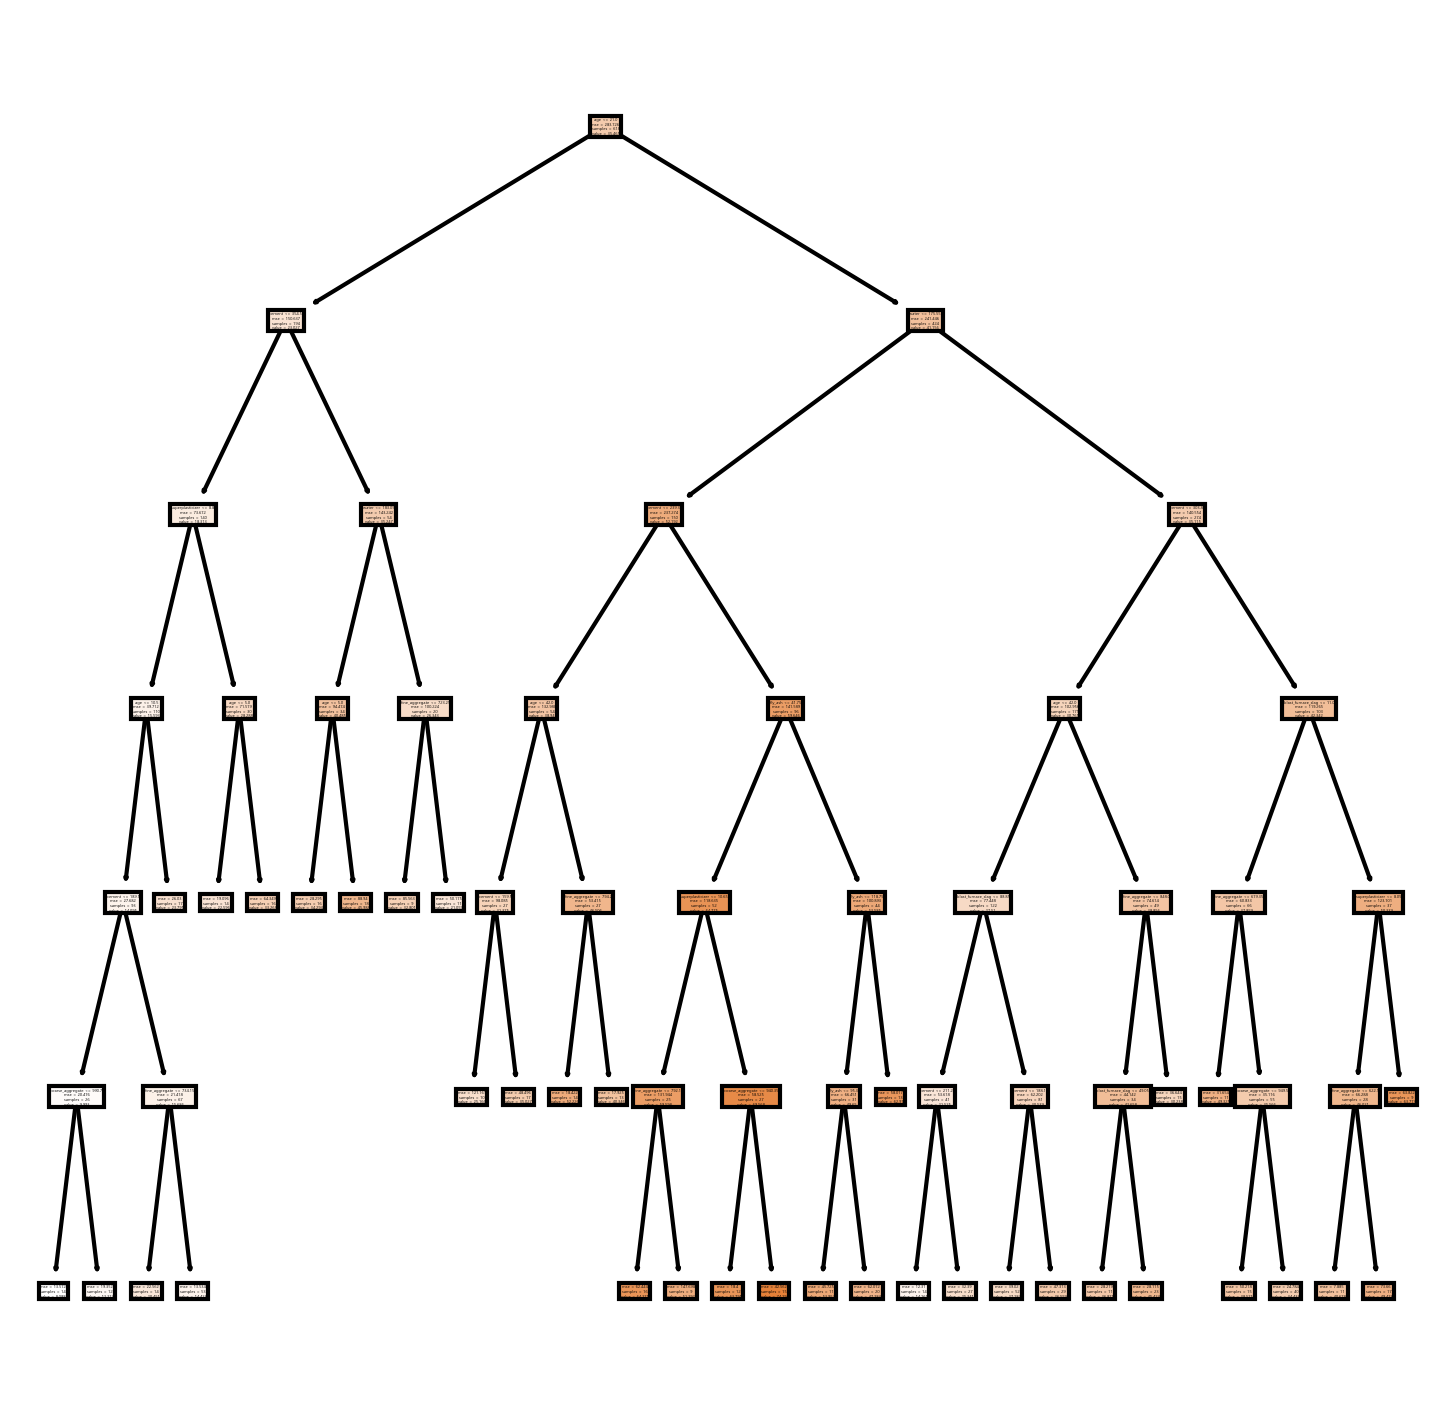

In [26]:
# 최종 모델 시각화
v_feature_name = df_train_x.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6, 6), dpi=300)
plot_tree(tree_graph, feature_names = v_feature_name, filled = True);

* 의사결정나무 노드에 대해 조건식을 너무 해석하고 싶은데 사이즈 조정을 해봐도 글이 안 보인다.   
  나의 숙련도 문제인 것 같은데 추후에 찾아보고 의사결정나무에 대해서는 다시 분석해보아야겠다.

### 결론 도출
##### - feature_importances_ : 설명변수의 중요도

In [24]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,age,0.363
0,cement,0.256
3,water,0.204
4,superplasticizer,0.048
6,fine_aggregate,0.046
1,blast_furnace_slag,0.043
2,fly_ash,0.033
5,coarse_aggregate,0.007


Text(0, 0.5, '변수')

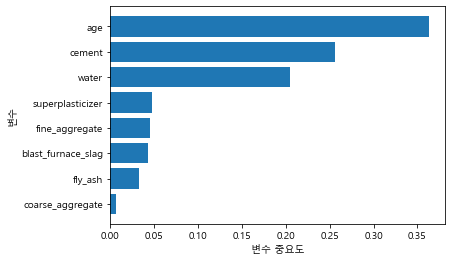

In [25]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

> 설명변수 중요도는 나무 생성과정에서 분리에 기여한 설명변수의 상대적인 중요도이다.   
  이 나무 모델에서는 **age, cement, water** 순으로 영향이 크다고 해석할 수 있다.  
  즉 이 모델에서 strength(힘)에 영향을 많이 주는 변수는 age(나이), cement(시멘트), water(물)이라는 뜻이다.   
  하지만, 모델 parameter를 다르게 준다면 설명변수의 중요도는 변할 것이다.    
  그래서 여기서 변수 중요도가 낮다고 해서 의미없는 변수는 아니다.

#### => 결론
> 모델 parameter 변경 전 score 값
  Score on training set : 0.996, 
  Score on test set : 0.790
  
> 변경 후 score 값
  Score on training set : 0.859, 
  Score on test set : 0.805
  
> **의사결정나무의 모델 parameter 잎사귀 노드 최소 자료 수, 분리 노드 최소 자료 수, 최대 깊이의 변경을 통해 
training set의 과대적합을 방지하였다고 볼 수 있다. 또한, test 데이터의 결정계수가 상승하였고 
train 성능과 test 성능의 차이가 크게 감소한 것으로 보아 일반성이 있는 모델이 되었다.
즉, 모델의 예측 성능이 좀 더 좋아진 모델이라고 볼 수 있고, 비즈니스적으로도 사용할 가치가 있는 모델임을 알 수 있다.**